## Compare TWO INMAP simulations

In [3]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os

def load_shapefile(shapefile_path):
    gdf = gpd.read_file(shapefile_path)
    if gdf.crs is None or gdf.crs.is_geographic:
        gdf = gdf.set_crs('EPSG:4269', allow_override=True)
    return gdf

def plot_difference_map(gdf1, gdf2, field, output_dir, year):
    # Ensure both GeoDataFrames have the same CRS
    if gdf1.crs != gdf2.crs:
        gdf2 = gdf2.to_crs(gdf1.crs)

    # Calculate the difference between the two shapefiles
    gdf1 = gdf1.rename(columns={field: f'{field}_1'})
    gdf2 = gdf2.rename(columns={field: f'{field}_2'})
    joined_gdf = gpd.sjoin(gdf1, gdf2, how="inner", op='intersects')
    joined_gdf['difference'] = joined_gdf[f'{field}_1'] - joined_gdf[f'{field}_2']

    # Define a color map for the difference
    color_map = mcolors.LinearSegmentedColormap.from_list(
        'custom_colormap',
        ['blue', 'white', 'red']
    )

    # Normalize the color map to the range of values you want to display
    norm = mcolors.BoundaryNorm([-50, -20, -10, -5, -1, 1, 5, 10, 20, 50], color_map.N)

    # Create a plot
    fig, ax = plt.subplots(1, 1, figsize=(15, 10), subplot_kw={'projection': ccrs.LambertConformal()})

    # Plot polygons without the grid lines
    gdf1.plot(ax=ax, facecolor='none', edgecolor='gray', linewidth=0.5, transform=ccrs.PlateCarree())


    # Plot the differences as filled polygons
    joined_gdf.plot(column='difference', cmap=color_map, linewidth=0.0, ax=ax, edgecolor='none', norm=norm, legend=False, transform=ccrs.PlateCarree(), alpha=0.9)

    # Add state and county borders for reference
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.STATES, linestyle=':', edgecolor='gray')

    # Color bar
    sm = plt.cm.ScalarMappable(cmap=color_map, norm=norm)
    sm._A = []
    cbar = fig.colorbar(sm, ax=ax, orientation='horizontal', pad=0.05, aspect=50)
    cbar.set_label('Difference in PM2.5 Concentration')

    # Titles and labels
    ax.set_title(f'Difference in PM2.5 Concentration between Two Runs ({year})', fontsize=16)

    # Set the extent to cover the CONUS region
    ax.set_extent([-125, -66.5, 24, 50], crs=ccrs.PlateCarree())

    # Save the plot to a file
    plt.savefig(os.path.join(output_dir, f'difference_pm25_map_{year}.png'), dpi=300, bbox_inches='tight')

    # Show the plot
    plt.show()

inmap_run_dir = '/Users/yunhalee/Documents/LOCAETA/RCM/INMAP/inmap-1.9.6-gridsplit/outputs/'
analysis_output_dir = '/Users/yunhalee/Documents/LOCAETA/LOCAETA_AQ/outputs/model_analysis/'
webdata_path = '/Users/yunhalee/Documents/LOCAETA/github/LOCAETA/WebTool/Data/'

# Define pairs of base and sensitivity runs
run_pairs = {
    #  'CO_CCS': {
    #      'base': 'base_nei2020/2020nei_output_run_steady.shp',
    #      'sens': 'CO_CCS/2020nei_output_run_steady.shp'
    #  },
    # 'CO_CCS_wo_NH3_VOC': {
    #     'base': 'base_nei2020/2020nei_output_run_steady.shp',
    #     'sens': 'CO_CCS_wo_NH3_VOC/2020nei_output_run_steady.shp'
    # },
    # 'CO_Suncor_wo_NH3_VOC': {
    #     'base': 'base_nei2020/2020nei_output_run_steady.shp',
    #     'sens': 'CO_Suncor_CCS_wo_NH3_VOC/2020nei_output_run_steady.shp'
    # }
    'NEI_no_Landfill_2001411':{
        'base': 'base_nei2020/2020nei_output_run_steady.shp',
        'sens': 'NEI_no_Landfill_2001411/2020nei_output_run_steady.shp'
    }
}

for run_name, paths in run_pairs.items():
    base_path = os.path.join(inmap_run_dir, paths['base'])
    sens_path = os.path.join(inmap_run_dir, paths['sens'])

    # Load the shapefiles
    gdf1 = load_shapefile(base_path)
    gdf2 = load_shapefile(sens_path)

    # Initialize a new GeoDataFrame for the differences
    gdf_diff = gdf1[['geometry']].copy()  # Copy only the geometry column

    columns = gdf1.columns.difference(['geometry', 'FIPS'])

    # Compute the differences and add them as new fields to gdf_diff
    for field in columns:
        gdf_diff[field] = gdf2[field] - gdf1[field]
        gdf_diff[field+'_base'] = gdf1[field]  # save base run results
    #gdf_diff.to_file(output_dir + 'National_LA_CSS_impact_diff_output.shp')

    # create a directory for each run pair
    run_output_dir = os.path.join(analysis_output_dir, run_name)
    if not os.path.exists(run_output_dir):
        os.makedirs(run_output_dir)

In [ ]:
print(gdf_diff.head())

In [2]:

import sys
import contextily as ctx
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import os

# Add the path to the main package directory
package_path = os.path.abspath('/Users/yunhalee/Documents/LOCAETA/LOCAETA_AQ/LOCAETA_AQ')
if package_path not in sys.path:
    sys.path.append(package_path)

import inmap_analysis

inmap_run_dir = '/Users/yunhalee/Documents/LOCAETA/RCM/INMAP/inmap-1.9.6-gridsplit/outputs/'
output_dir = '/Users/yunhalee/Documents/LOCAETA/LOCAETA_AQ/outputs/model_analysis/'
webdata_path = '/Users/yunhalee/Documents/LOCAETA/github/LOCAETA/WebTool/Data/'

# Define pairs of base and sensitivity runs
run_pairs = {
    #  'CO_CCS': {
    #      'base': 'base_nei2020/2020nei_output_run_steady.shp',
    #      'sens': 'CO_CCS/2020nei_output_run_steady.shp'
    #  },
    # 'CO_CCS_wo_NH3_VOC': {
    #     'base': 'base_nei2020/2020nei_output_run_steady.shp',
    #     'sens': 'CO_CCS_wo_NH3_VOC/2020nei_output_run_steady.shp'
    # },
    'CO_Suncor_CCS_wo_NH3_VOC': {
        'base': 'base_nei2020/2020nei_output_run_steady.shp',
        'sens': 'CO_Suncor_CCS_wo_NH3_VOC/2020nei_output_run_steady.shp'
    },
    'CO_Cherokee_CCS_wo_NH3_VOC': {
        'base': 'base_nei2020/2020nei_output_run_steady.shp',
        'sens': 'CO_Cherokee_CCS_wo_NH3_VOC/2020nei_output_run_steady.shp'
    }
    # 'NEI_no_Landfill_2001411':{
    #     'base': 'base_nei2020/2020nei_output_run_steady.shp',
    #     'sens': 'NEI_no_Landfill_2001411/2020nei_output_run_steady.shp'
    # }
}

inmap_to_geojson = ['TotalPM25']

state_regions = {"CO": '08'}

for run_name, paths in run_pairs.items():
    gdf_diff = inmap_analysis.process_run_pair(run_name, paths, inmap_run_dir)

    # create a directory for each run pair
    run_output_dir = os.path.join(output_dir, run_name)
    if not os.path.exists(run_output_dir):
        os.makedirs(run_output_dir)

    # compare the changes of PopD matches PM25.
    #inmap_analysis.compare_pm25_mortality_changes(gdf_diff,run_output_dir, run_name)
    min_pop_idx = gdf_diff['TotalPopD'].idxmin()
    gdf_diff = gdf_diff.drop(index=min_pop_idx)
    
    for v in inmap_to_geojson:
        #inmap_analysis.create_interactive_map(gdf_diff, v, run_output_dir)

        ## This plot must only for the state (otherwise it takes very long to plot the map)
        # note - subset gdf_diff for the state of your interest (unforunately, INMAP doesn't carry FIPS)
        for state, state_fips in state_regions.items():
            print(f"subsetting the dataset for the state {state_fips}")
            gdf_subset = inmap_analysis.subset_state(gdf_diff, state_fips)
            print(gdf_subset.shape)
            inmap_analysis.plot_spatial_distribution_percent_change_with_basemap(gdf_subset, v, run_output_dir)



Processing CO_Suncor_CCS_wo_NH3_VOC - Base: /Users/yunhalee/Documents/LOCAETA/RCM/INMAP/inmap-1.9.6-gridsplit/outputs/base_nei2020/2020nei_output_run_steady.shp, Sensitivity: /Users/yunhalee/Documents/LOCAETA/RCM/INMAP/inmap-1.9.6-gridsplit/outputs/CO_Suncor_CCS_wo_NH3_VOC/2020nei_output_run_steady.shp
subsetting the dataset for the state 08
Reprojecting from EPSG:3857 to PROJCS["Lambert_Conformal_Conic",GEOGCS["GCS_unnamed ellipse",DATUM["unknown",SPHEROID["Unknown",6370997,0]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["latitude_of_origin",40],PARAMETER["central_meridian",-97],PARAMETER["standard_parallel_1",33],PARAMETER["standard_parallel_2",45],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
(828, 37)
Processing CO_Cherokee_CCS_wo_NH3_VOC - Base: /Users/yunhalee/Documents/LOCAETA/RCM/INMAP/inmap-1.9.6-gridsplit/outputs/b

In [31]:
# read county polygon information from this shapefile (needed for non-point sources)
shapefile_path = "/Users/yunhalee/Documents/LOCAETA/NEI_emissions/NEI_2020_gaftp_Jun2024/emiss_shp2020/Census/cb_2020_us_county_500k.shp"
gdf_fips = gpd.read_file(shapefile_path)
print(f"unique FIPS are {gdf_fips['STATEFP'].unique()}")
gdf_diff = gdf_diff.to_crs(epsg=3857)
gdf_fips = gdf_fips.to_crs(epsg=3857)

# Get all county geometries for the state and merge them into a single geometry
state_geom = gdf_fips[gdf_fips['STATEFP'] == state_fips].geometry.unary_union

print(state_geom)

# Subset your dataset using spatial intersection
gdf_co = gdf_diff[gdf_diff.intersects(state_geom)]

# check new dataset
print(gdf_co.head())

unique FIPS are ['01' '04' '05' '06' '12' '10' '11' '09' '08' '16' '13' '17' '18' '22'
 '21' '20' '19' '24' '23' '26' '25' '27' '29' '30' '28' '34' '32' '33'
 '31' '36' '35' '37' '38' '40' '39' '42' '45' '41' '48' '47' '46' '49'
 '51' '53' '55' '54' '56' '02' '72' '66' '69' '60' '78' '44' '50' '15']
POLYGON ((-11799558.129304854 4438468.020654597, -11799584.608414274 4438467.995404459, -11800569.188627852 4438458.038655882, -11800604.51758892 4438457.681385442, -11804047.754822418 4438430.664214769, -11808948.042329175 4438392.214498401, -11810999.17563056 4438376.120485417, -11822293.450577628 4438287.501520637, -11824402.122272618 4438295.724121067, -11827440.418553947 4438307.571731128, -11827548.398460018 4438310.638016631, -11832513.693027359 4438255.166261451, -11837685.080591975 4438299.318336795, -11838064.082838312 4438302.554174943, -11845735.6469228 4438274.37027553, -11852800.986546986 4438248.413598322, -11852884.717071591 4438248.105989114, -11855529.428272767 4438238.389

In [28]:
gdf_state = gpd.sjoin(gdf_diff, gdf_fips[gdf_fips["STATEFP"] == "08"], how="inner", predicate="intersects")
print(f"Subset contains {len(gdf_state)} records.")

Subset contains 64 records.


/var/folders/c8/7t_s93rd22l4mk18hd7pj0d80000gn/T/ipykernel_66395/3699510876.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: PROJCS["Lambert_Conformal_Conic",GEOGCS["GCS_unnam ...
Right CRS: EPSG:4269

  gdf_state = gpd.sjoin(gdf_diff, gdf_fips[gdf_fips["STATEFP"] == "08"], how="inner", predicate="intersects")


In [ ]:
import geopandas as gpd
import folium
from folium import LayerControl
import branca.colormap as cm

def create_interactive_map(gdf_diff, field, output_dir):
    # Ensure the GeoDataFrame has a valid CRS
    if gdf_diff.crs is None:
        gdf_diff.set_crs(epsg=4326, inplace=True)
    else:
        gdf_diff.to_crs(epsg=4326, inplace=True)

    # Create an index column for referencing in the choropleth map
    # gdf_diff = gdf_diff.reset_index()

    # Create a custom colormap
    min_value = gdf_diff[field].min()
    max_value = gdf_diff[field].max()

    colormap = cm.LinearColormap(
        colors=['blue', 'white', 'red'],
        vmin=-2, #min_value, #-2, #0.5,
        vmax=2, #max_value, #2, #0.5,
        caption=f'{field} Difference'
    )

    # Create a base map centered around the centroid of the GeoDataFrame
    map_center = [gdf_diff.geometry.centroid.y.mean(), gdf_diff.geometry.centroid.x.mean()]
    m = folium.Map(location=map_center, zoom_start=6)

    # Add the GeoDataFrame to the map with the custom colormap
    folium.GeoJson(
        gdf_diff,
        name=field,
        style_function=lambda x: {
            'fillColor': colormap(x['properties'][field]),
            'color': 'black',
            'weight': 0.5,
            'fillOpacity': 0.7,
        },
        tooltip=folium.features.GeoJsonTooltip(
            fields=[field],
            aliases=[f'{field} Difference:'],
            localize=True
        )
    ).add_to(m)

    # Add the colormap to the map
    colormap.add_to(m)

    # Add layer control to toggle different layers
    LayerControl().add_to(m)

    # Find the location of the maximum value
    max_idx = gdf_diff[field].idxmax()
    max_location = gdf_diff.loc[max_idx, 'geometry'].centroid

    # Add a circle marker at the location with the maximum value
    folium.CircleMarker(
        location=[max_location.y, max_location.x],
        radius=10,  # Adjust the radius as needed
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.6,
        popup=f'Max {field}: {max_value}'
    ).add_to(m)

    # Find the location of the minimum value
    min_idx = gdf_diff[field].idxmin()
    min_location = gdf_diff.loc[min_idx, 'geometry'].centroid

    # Add a circle marker at the location with the minimum value
    folium.CircleMarker(
        location=[min_location.y, min_location.x],
        radius=10,  # Adjust the radius as needed
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.6,
        popup=f'Min {field}: {min_value}'
    ).add_to(m)

    # Save the map to an HTML file
    m.save(f"{output_dir}Only_LA_CSS_{field}_interactive_map.html")

    # Display the map in Jupyter Notebook (if using Jupyter)
    return m

field = 'TotalPopD' 
output_dir = '/Users/yunhalee/Documents/LOCAETA/RCM/model_eval/'
create_interactive_map(gdf_diff, field, output_dir)

In [ ]:
# This is for SR matrix

# Compute column sums
col_sums_list = ['deathsK','deathsL']
column_sums = gdf_diff[col_sums_list].sum()
print("Column Sums:\n", column_sums)


# Compute area-weighted averages
gdf_diff['area'] = gdf_diff.geometry.area
area_weighted_averages = {}

print(gdf_diff.columns)
area_weight_list =['pNH4','pNO3','pSO4','PrimPM25','TotalPM25' ]
for field in area_weight_list:
    area_weighted_averages[field] = (gdf_diff[field] * gdf_diff['area']).sum() / gdf_diff['area'].sum()

print("Area-Weighted Averages:")
for key, value in area_weighted_averages.items():
    print(f"{key}: {value}")

In [ ]:
## ATTENTION ### 
# I am going to remove the row with the minimum TotalPopD, which doesn't look right. 
min_pop_idx = gdf_diff['TotalPopD'].idxmin()
gdf_diff = gdf_diff.drop(index=min_pop_idx)


# Compute column sums
col_sums_list = ['AsianD', 'BlackD', 'LatinoD', 'NativeD','WhitNoLatD', 'TotalPopD']
column_sums = gdf_diff[col_sums_list].sum()
print("Column Sums:\n", column_sums)

# Compute area-weighted averages
gdf_diff['area'] = gdf_diff.geometry.area
area_weighted_averages = {}

area_weight_list =['NH3','NOx','SOA','SOx', 'PNH4','PNO3','PSO4','PrimPM25','TotalPM25' ]
for field in area_weight_list:
    area_weighted_averages[field] = (gdf_diff[field] * gdf_diff['area']).sum() / gdf_diff['area'].sum()

print("Area-Weighted Averages:")
for key, value in area_weighted_averages.items():
    print(f"{key}: {value}")

## Plot area_weighted_AQ changes from all run

In [3]:
import pandas as pd
import os

main_dir = '/Users/yunhalee/Documents/LOCAETA/LOCAETA_AQ/outputs/model_analysis/'
run_list = ['LA_CCS', 'LA_CCS_noNH3'] # ['CO_CCS', 'CO_CCS_wo_NH3_VOC', 'CO_Suncor_wo_NH3_VOC','CO_Cherokee_wo_NH3_VOC', 'NEI_no_Landfill_2001411']
target_file = 'area_weighted_averages.csv'
final_output = 'area_weighted_averages_all_CO_runs.png'
 
combined_df = None

for run in run_list:
    output_path = os.path.join(main_dir, run)
    df = pd.read_csv(output_path + '/'+target_file)

    df.rename(columns={"Area-Weighted Average": run}, inplace=True)

    # Merge on 'Species' column
    if combined_df is None:
        combined_df = df  # First dataframe, set as base
    else:
        combined_df = pd.merge(combined_df, df, on="Species", how="outer")

# Print and check final DataFrame
print(combined_df)


     Species    LA_CCS  LA_CCS_noNH3
0        NH3  0.002203      0.000000
1        NOx -0.005652     -0.005652
2       PNH4  0.002885      0.000000
3       PNO3 -0.000574     -0.000574
4       PSO4 -0.003114     -0.003114
5   PrimPM25 -0.000669     -0.000669
6        SOA  0.000006      0.000006
7        SOx -0.000786     -0.000786
8  TotalPM25 -0.001466     -0.004351


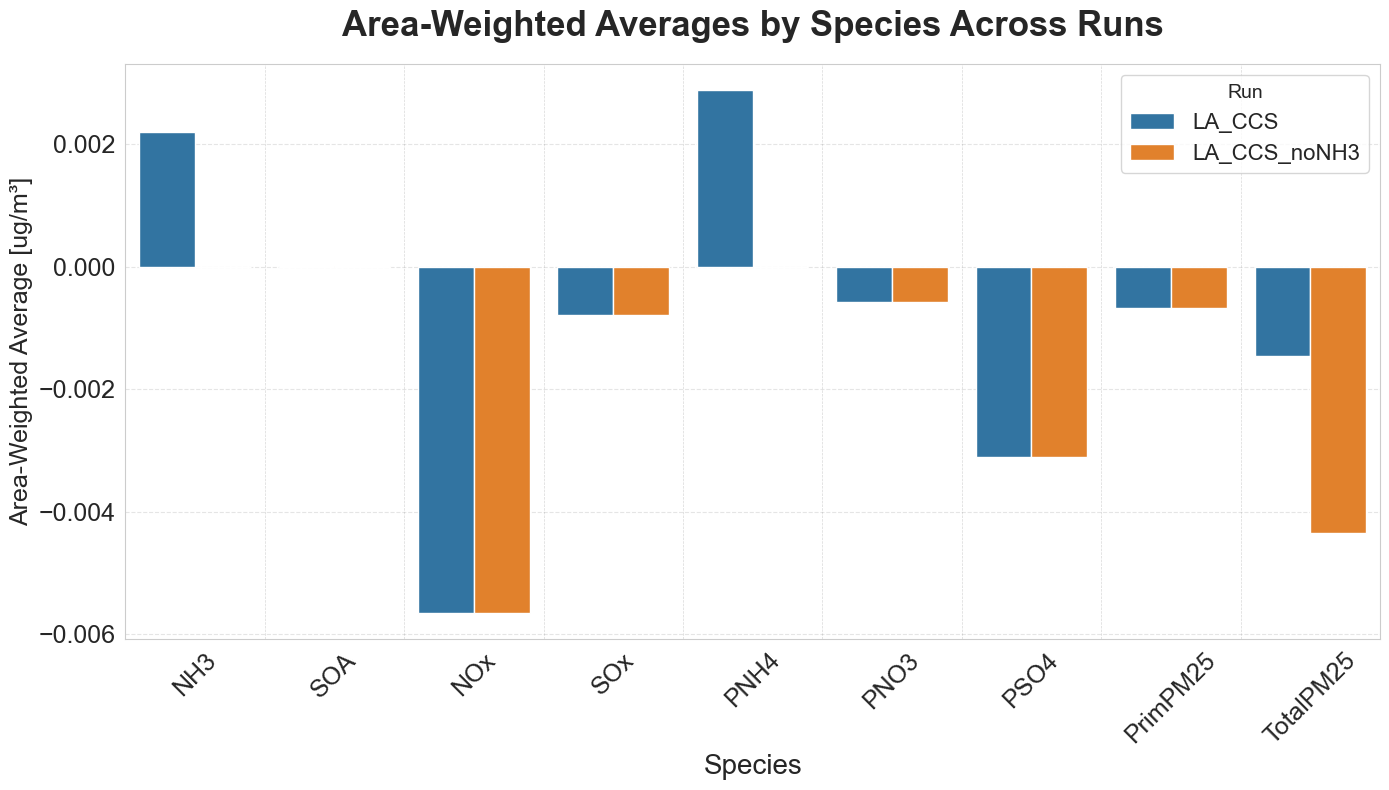

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from pandas.api.types import CategoricalDtype

# Define your desired order of species
species_order = ["NH3", "SOA", "NOx","SOx","PNH4", "PNO3", "PSO4", "PrimPM25", "TotalPM25"]  # Modify as needed

# Convert DataFrame from wide to long format
df_long = combined_df.melt(id_vars=["Species"], var_name="Run", value_name="Area-Weighted Average")

# Convert "Species" to a categorical type with the defined order
species_cat = CategoricalDtype(categories=species_order, ordered=True)
df_long["Species"] = df_long["Species"].astype(species_cat)

# Sort the DataFrame to ensure correct plotting order
df_long = df_long.sort_values("Species")


# Set Seaborn style
sns.set_style("whitegrid")

# Create figure and bar plot
plt.figure(figsize=(14, 8))
ax = sns.barplot(data=df_long, x="Species", y="Area-Weighted Average", hue="Run", palette="tab10")

# Customize the plot
plt.title("Area-Weighted Averages by Species Across Runs", fontsize=25, fontweight="bold", pad=20)
plt.xlabel("Species", fontsize=20)
plt.ylabel("Area-Weighted Average [ug/m³]", fontsize=18)
plt.xticks(rotation=45, fontsize=18)
plt.yticks(fontsize=18)
plt.legend(title="Run", title_fontsize=14, fontsize=16, frameon=True)
plt.grid(axis="y", linestyle="--", alpha=0.5)

# Add subtle vertical gridlines between categories
for i in range(len(ax.get_xticks())):
    ax.axvline(x=i - 0.5, color='grey', linestyle='--', linewidth=0.5, alpha=0.3)

# Show plot
plt.tight_layout()
plt.savefig(main_dir+final_output, dpi=300, bbox_inches='tight')
plt.show()
